# Modeling to Classify Koi Fish Varieties and Traits

#### Multi-label, multi-class image classification for koi fish varieties and traits. The current dataset includes two varieties: Kohaku, Sanke and Showa, and two traits: Tancho and GinRin, for a total of 5 labels. The goal is to predict all applicable labels correctly for each image. 

In [45]:
# Basic imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from PIL import Image

from torch.utils.data import DataLoader
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Import functions from src
from src.data_loader import (load_json_to_df, multi_hot_encode_row, stratified_train_test_val, CustomMultiLabelDataset,
                             tensor_checker)
from src.transforms import transform_basic, transform_img_aug
from src.models import get_resnet18_model, get_resnet18_model_frozen
from src.train import train_model, get_class_weights, train_model_earlystop_reducelronplateau
from src.utils import plot_train_val_losses
from src.evaluate import evaluate_model_flare

device = "mps" if torch.backends.mps.is_available() else "cpu"

# Set reload updated modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preparing Data for Modeling

In [2]:
LABELS = ['kohaku', 'sanke', 'showa', 'tancho', 'gin']

# Define the number of classes
num_classes = len(LABELS)
num_classes

5

In [3]:
# Load data
df = load_json_to_df('0_main_dataset/data/df_5labels.json')

# Multi-hot-encode labels
df = multi_hot_encode_row(df, labels=LABELS)

# Stratified train-test-val split
train_df, test_df, val_df = stratified_train_test_val(df['image_path'],
                                                      df['mhe'],
                                                      train_testval_size=0.3,
                                                      test_val_size=0.5,
                                                      print_shapes=False)

# Define the transform
transform = transform_basic()

# Create the datasets
train_ds = CustomMultiLabelDataset(train_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)
test_ds = CustomMultiLabelDataset(test_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)
val_ds = CustomMultiLabelDataset(val_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# Check the tensors
tensor_checker(train_loader, test_loader, val_loader)

<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])


## Balancing Classes

In [4]:
# Use BCEWithLogitsLoss's pos_weights to balance class weights
# step 1: calculate the weights
label_counts = train_df['mhe'].sum(axis=0)
print(f'label_counts: {label_counts}')

total_samples = train_df['mhe'].shape[0]
print(f'total_samples: {total_samples}')

pos_weights = total_samples / label_counts
print(f'pos_weights: {pos_weights}')

pos_weights = torch.tensor(pos_weights, dtype=torch.float32)
pos_weights = pos_weights.to(device)

label_counts: [181 165 126  42 191]
total_samples: 601
pos_weights: [ 3.32044199  3.64242424  4.76984127 14.30952381  3.14659686]


## MODEL 1: Transfer Learning with ResNet18 with frozen layers

In [5]:
# Calculate the class balance
pos_weights = get_class_weights(train_df, device)

# Define the model (with FROZEN layers)
model = get_resnet18_model_frozen(num_classes)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a scheduler to implement reducing learning rate on plateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Train the model
num_epochs = 200


train_losses, train_accuracies, val_losses, val_accuracies = train_model_earlystop_reducelronplateau(model,
                                                                                                    train_loader,
                                                                                                    val_loader,
                                                                                                    criterion,
                                                                                                    optimizer,
                                                                                                    device,
                                                                                                    scheduler,
                                                                                                    num_epochs=num_epochs,
                                                                                                    patience_early_stop=5,
                                                                                                    best_model_name='best_model_frozen_ResNet18.pth')

label_counts: [181 165 126  42 191]
total_samples: 601
pos_weights: [ 3.32044199  3.64242424  4.76984127 14.30952381  3.14659686]
Epoch 1/200 | Train Loss: 2.5937, Train Acc: 75.91% | Val Loss: 2.7230, Val Acc: 78.57% | LR: 0.001000
Epoch 2/200 | Train Loss: 2.0453, Train Acc: 80.93% | Val Loss: 2.2048, Val Acc: 79.68% | LR: 0.001000
Epoch 3/200 | Train Loss: 1.7635, Train Acc: 85.96% | Val Loss: 1.9052, Val Acc: 83.65% | LR: 0.001000
Epoch 4/200 | Train Loss: 1.5635, Train Acc: 87.09% | Val Loss: 1.6745, Val Acc: 87.46% | LR: 0.001000
Epoch 5/200 | Train Loss: 1.4179, Train Acc: 88.69% | Val Loss: 1.5061, Val Acc: 88.89% | LR: 0.001000
Epoch 6/200 | Train Loss: 1.3035, Train Acc: 89.42% | Val Loss: 1.3990, Val Acc: 89.52% | LR: 0.001000
Epoch 7/200 | Train Loss: 1.2325, Train Acc: 90.52% | Val Loss: 1.2741, Val Acc: 90.32% | LR: 0.001000
Epoch 8/200 | Train Loss: 1.1688, Train Acc: 91.11% | Val Loss: 1.1830, Val Acc: 91.75% | LR: 0.001000
Epoch 9/200 | Train Loss: 1.1017, Train Acc: 9

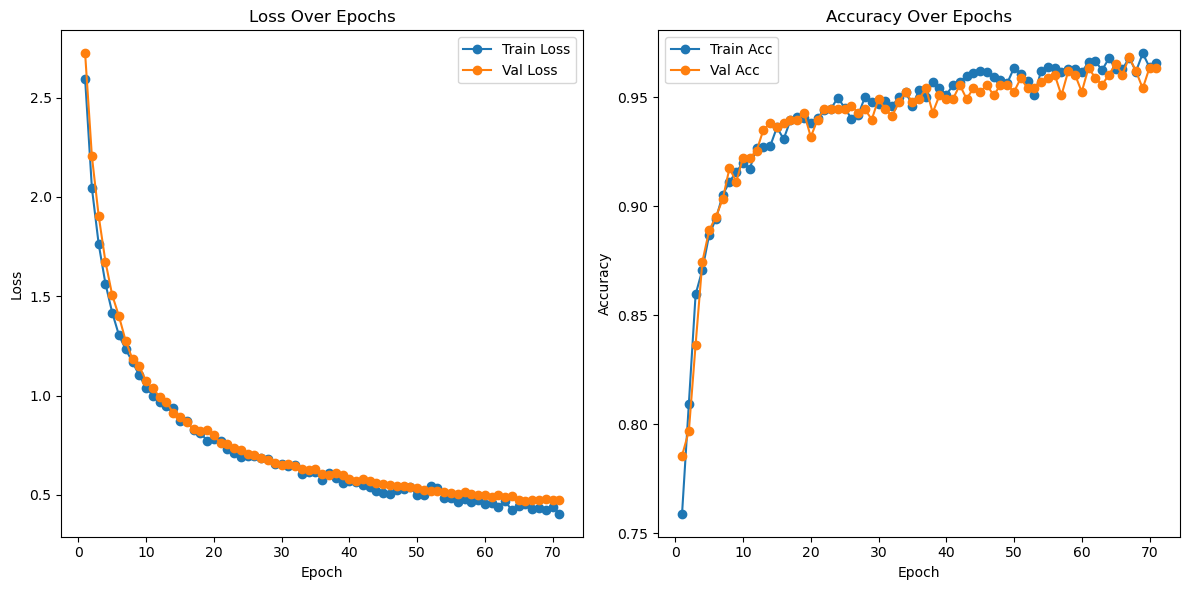

In [6]:
# Plot the train and val losses and accuracies
plot_train_val_losses(len(val_losses), train_losses, train_accuracies, val_losses, val_accuracies)

Validation Accuracy: 0.8571, F1 Score: 0.9217, Precision: 0.9325, Recall: 0.9114
              precision    recall  f1-score   support

      kohaku       1.00      0.94      0.97        35
       sanke       0.79      0.79      0.79        14
       showa       0.93      0.93      0.93        43
      tancho       1.00      1.00      1.00        13
         gin       0.95      0.90      0.92        59

   micro avg       0.94      0.91      0.93       164
   macro avg       0.93      0.91      0.92       164
weighted avg       0.94      0.91      0.93       164
 samples avg       0.93      0.92      0.92       164



/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


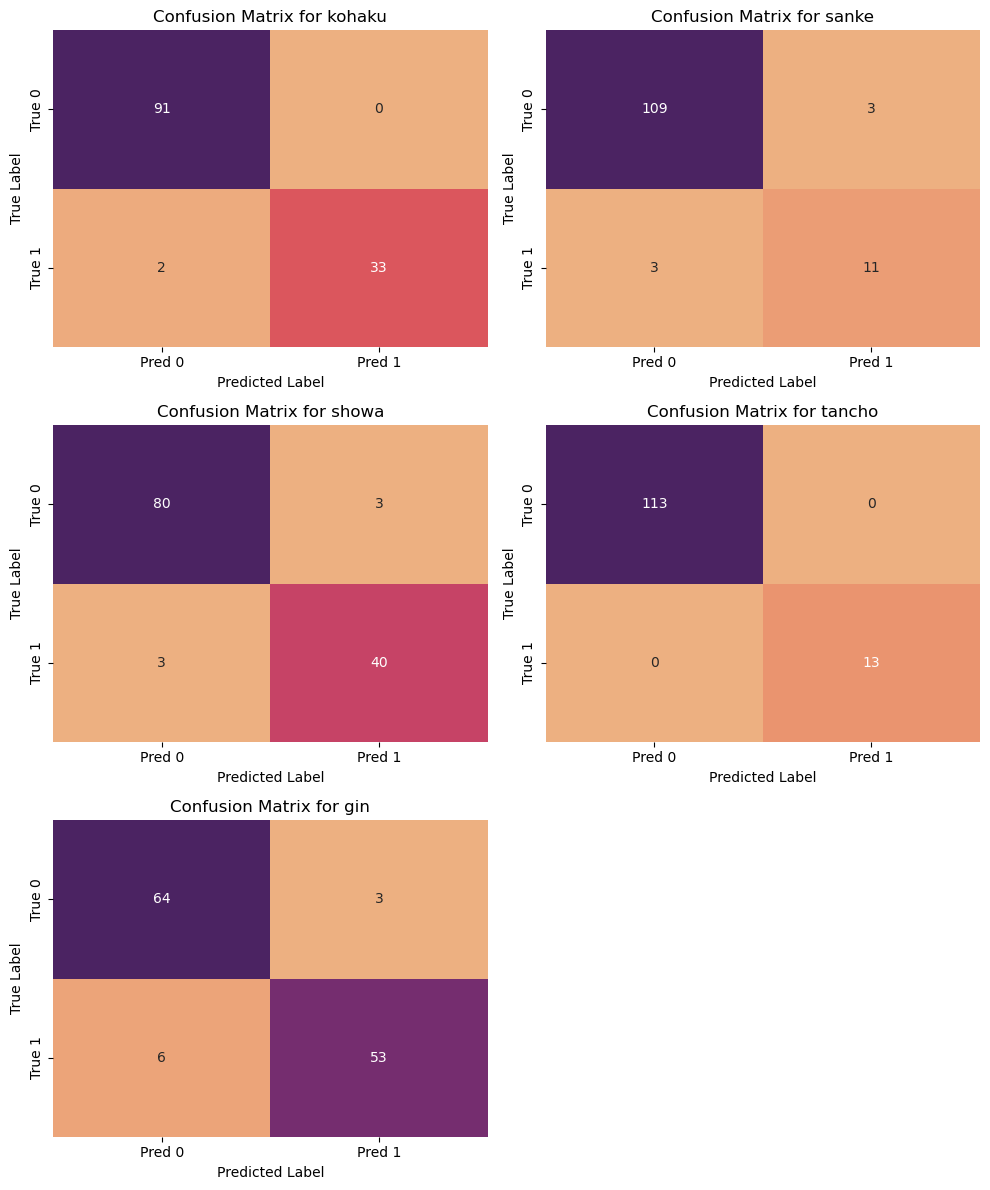

In [7]:
# Evaluate the model
all_preds, all_labels, scores = evaluate_model_flare(model, val_loader, device, class_labels=LABELS)

## MODEL 2: Apply Image Augmentation

In [8]:
# Define the transform
transform_img_aug = transform_img_aug()
transform = transform_basic()

# Create the datasets
train_ds = CustomMultiLabelDataset(train_df, 'image_path','mhe', dir_path='pictures/', transforms=transform_img_aug)
test_ds = CustomMultiLabelDataset(test_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)
val_ds = CustomMultiLabelDataset(val_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# Check the tensors
tensor_checker(train_loader, test_loader, val_loader)

<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])


In [9]:
# Define the model (with FROZEN layers)
model = get_resnet18_model_frozen(num_classes)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a scheduler to implement reducing learning rate on plateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Train the model
num_epochs = 200


train_losses, train_accuracies, val_losses, val_accuracies = train_model_earlystop_reducelronplateau(model,
                                                                                                    train_loader,
                                                                                                    val_loader,
                                                                                                    criterion,
                                                                                                    optimizer,
                                                                                                    device,
                                                                                                    scheduler,
                                                                                                    num_epochs=num_epochs,
                                                                                                    patience_early_stop=10,
                                                                                                    best_model_name='best_model_frozen_ResNet18_augmentation.pth')

Epoch 1/200 | Train Loss: 2.6078, Train Acc: 75.77% | Val Loss: 2.5147, Val Acc: 77.62% | LR: 0.001000
Epoch 2/200 | Train Loss: 2.0867, Train Acc: 80.40% | Val Loss: 2.1324, Val Acc: 79.52% | LR: 0.001000
Epoch 3/200 | Train Loss: 1.7847, Train Acc: 83.83% | Val Loss: 1.8405, Val Acc: 83.02% | LR: 0.001000
Epoch 4/200 | Train Loss: 1.6066, Train Acc: 86.32% | Val Loss: 1.6546, Val Acc: 86.19% | LR: 0.001000
Epoch 5/200 | Train Loss: 1.4518, Train Acc: 88.32% | Val Loss: 1.5039, Val Acc: 85.71% | LR: 0.001000
Epoch 6/200 | Train Loss: 1.3872, Train Acc: 88.62% | Val Loss: 1.4103, Val Acc: 89.05% | LR: 0.001000
Epoch 7/200 | Train Loss: 1.3070, Train Acc: 89.12% | Val Loss: 1.2888, Val Acc: 90.63% | LR: 0.001000
Epoch 8/200 | Train Loss: 1.2219, Train Acc: 90.28% | Val Loss: 1.2198, Val Acc: 91.43% | LR: 0.001000
Epoch 9/200 | Train Loss: 1.1524, Train Acc: 90.42% | Val Loss: 1.1496, Val Acc: 92.06% | LR: 0.001000
Epoch 10/200 | Train Loss: 1.1267, Train Acc: 91.05% | Val Loss: 1.1155, 

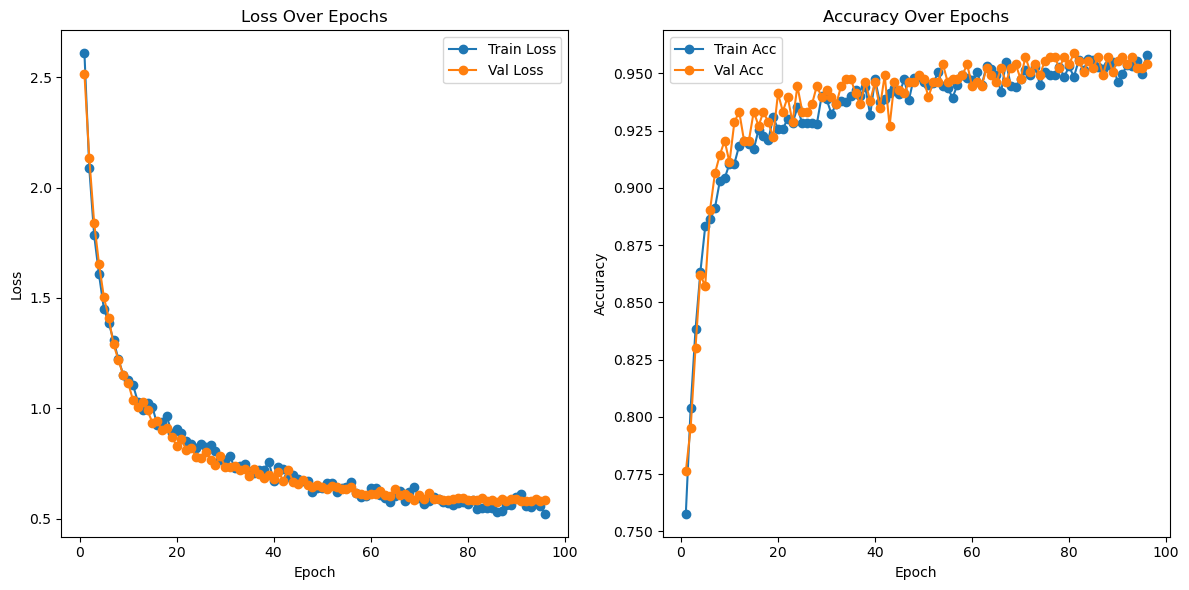

In [10]:
# Plot the train and val losses and accuracies
plot_train_val_losses(len(val_losses), train_losses, train_accuracies, val_losses, val_accuracies)

Validation Accuracy: 0.8016, F1 Score: 0.8994, Precision: 0.9662, Recall: 0.8503
              precision    recall  f1-score   support

      kohaku       1.00      0.91      0.96        35
       sanke       1.00      0.64      0.78        14
       showa       0.89      0.91      0.90        43
      tancho       1.00      0.92      0.96        13
         gin       0.94      0.86      0.90        59

   micro avg       0.95      0.87      0.91       164
   macro avg       0.97      0.85      0.90       164
weighted avg       0.95      0.87      0.91       164
 samples avg       0.91      0.89      0.89       164



/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


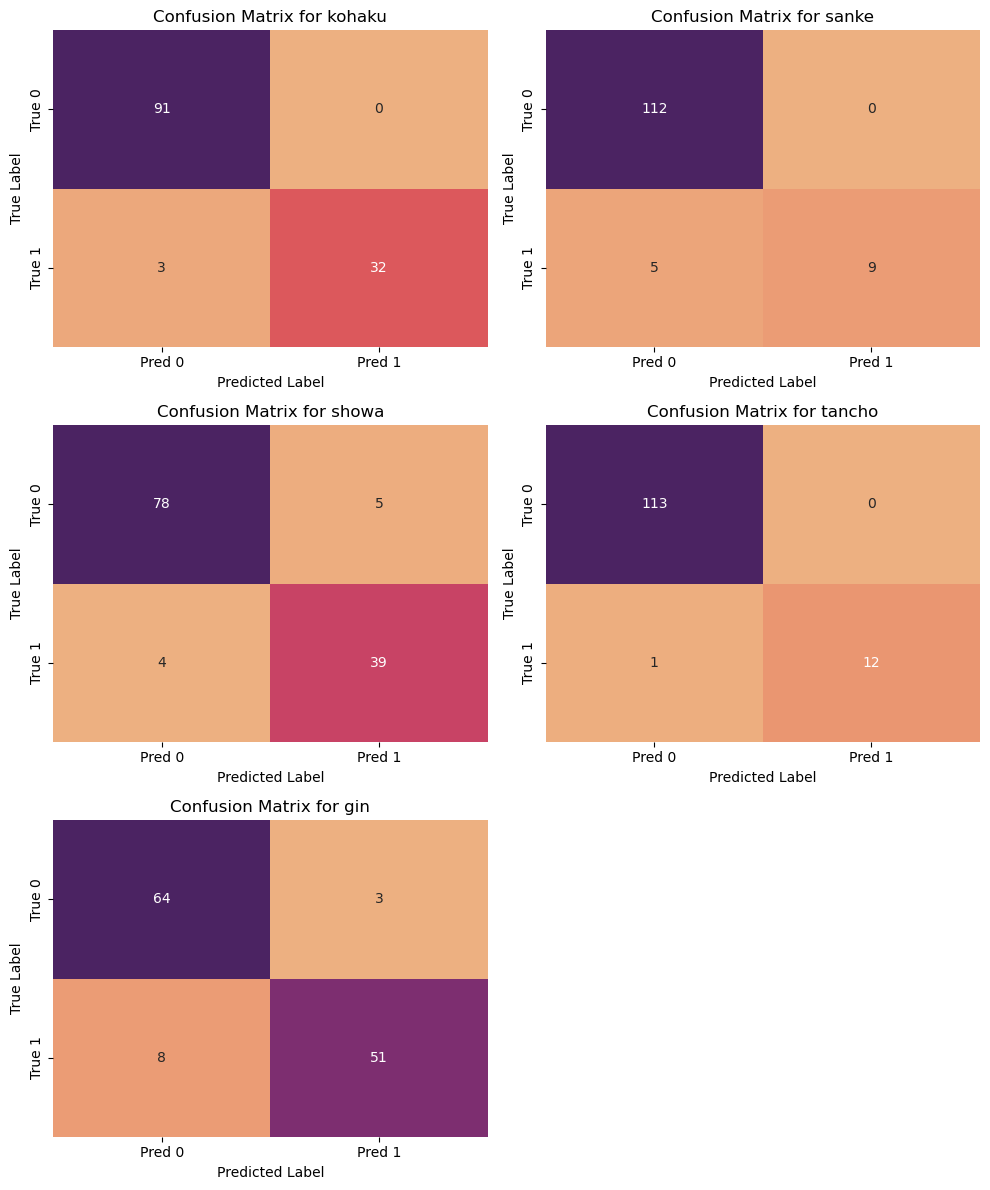

In [11]:
# Evaluate the model
all_preds, all_labels, scores = evaluate_model_flare(model, val_loader, device, class_labels=LABELS)

## MODEL 3: Unfreeze ResNet18

In [12]:
# Define the model (with UNFROZEN FC layer)
model = get_resnet18_model(num_classes)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a scheduler to implement reducing learning rate on plateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Train the model
num_epochs = 200


train_losses, train_accuracies, val_losses, val_accuracies = train_model_earlystop_reducelronplateau(model,
                                                                                                    train_loader,
                                                                                                    val_loader,
                                                                                                    criterion,
                                                                                                    optimizer,
                                                                                                    device,
                                                                                                    scheduler,
                                                                                                    num_epochs=num_epochs,
                                                                                                    patience_early_stop=10,
                                                                                                    best_model_name='best_model_unfrozen_ResNet18_augmentation.pth')

Epoch 1/200 | Train Loss: 1.4481, Train Acc: 86.79% | Val Loss: 4.6896, Val Acc: 83.17% | LR: 0.001000
Epoch 2/200 | Train Loss: 0.9479, Train Acc: 91.45% | Val Loss: 1.2072, Val Acc: 87.30% | LR: 0.001000
Epoch 3/200 | Train Loss: 0.7346, Train Acc: 92.81% | Val Loss: 0.9242, Val Acc: 90.79% | LR: 0.001000
Epoch 4/200 | Train Loss: 0.5042, Train Acc: 95.24% | Val Loss: 0.5950, Val Acc: 94.76% | LR: 0.001000
Epoch 5/200 | Train Loss: 0.5277, Train Acc: 95.47% | Val Loss: 0.7214, Val Acc: 93.49% | LR: 0.001000
Epoch 6/200 | Train Loss: 0.4967, Train Acc: 95.31% | Val Loss: 0.4548, Val Acc: 95.24% | LR: 0.001000
Epoch 7/200 | Train Loss: 0.4116, Train Acc: 96.31% | Val Loss: 0.8939, Val Acc: 91.11% | LR: 0.001000
Epoch 8/200 | Train Loss: 0.4397, Train Acc: 96.11% | Val Loss: 0.3916, Val Acc: 95.56% | LR: 0.001000
Epoch 9/200 | Train Loss: 0.3142, Train Acc: 97.27% | Val Loss: 0.6195, Val Acc: 93.65% | LR: 0.001000
Epoch 10/200 | Train Loss: 0.3301, Train Acc: 97.40% | Val Loss: 0.4552, 

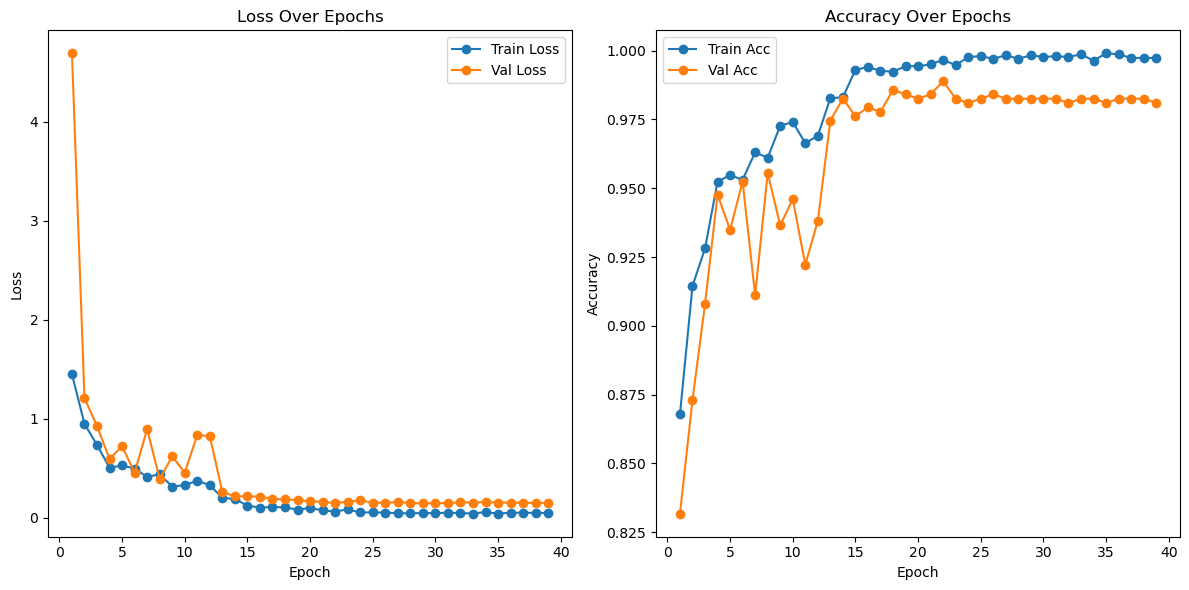

In [13]:
# Plot the train and val losses and accuracies
plot_train_val_losses(len(val_losses), train_losses, train_accuracies, val_losses, val_accuracies)

Validation Accuracy: 0.9286, F1 Score: 0.9659, Precision: 0.9728, Recall: 0.9595
              precision    recall  f1-score   support

      kohaku       1.00      1.00      1.00        35
       sanke       0.93      0.93      0.93        14
       showa       0.95      0.95      0.95        43
      tancho       1.00      1.00      1.00        13
         gin       0.98      0.92      0.95        59

   micro avg       0.97      0.95      0.96       164
   macro avg       0.97      0.96      0.97       164
weighted avg       0.98      0.95      0.96       164
 samples avg       0.97      0.96      0.96       164



/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


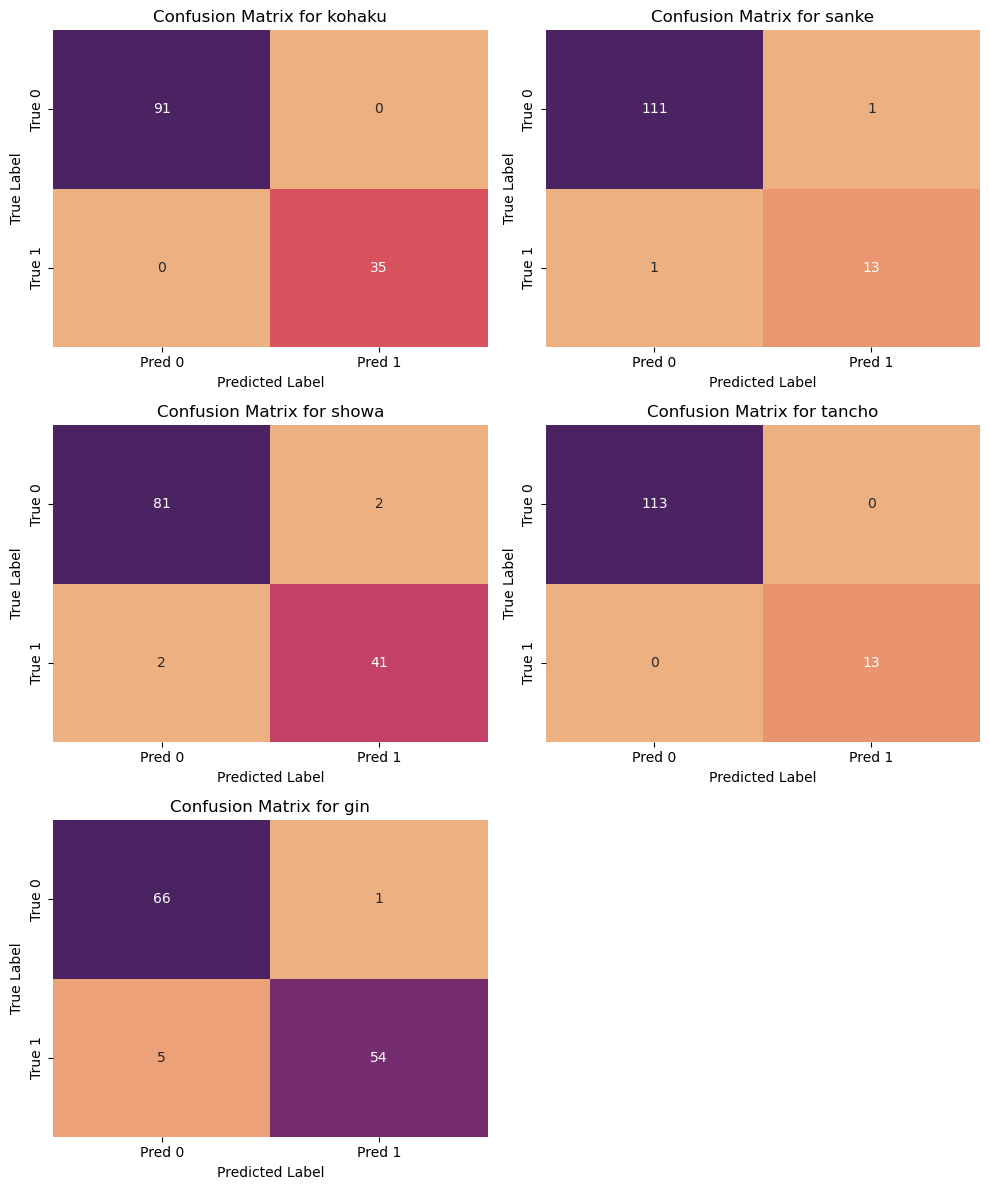

In [14]:
# Evaluate the model
all_preds, all_labels, scores = evaluate_model_flare(model, val_loader, device, class_labels=LABELS)

# Evaluate on Test Data

Validation Accuracy: 0.9697, F1 Score: 0.9805, Precision: 0.9773, Recall: 0.9849
              precision    recall  f1-score   support

      kohaku       0.97      1.00      0.98        32
       sanke       1.00      0.94      0.97        17
       showa       1.00      1.00      1.00        53
      tancho       0.92      1.00      0.96        11
         gin       1.00      0.98      0.99        60

   micro avg       0.99      0.99      0.99       173
   macro avg       0.98      0.98      0.98       173
weighted avg       0.99      0.99      0.99       173
 samples avg       0.98      0.98      0.98       173



/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

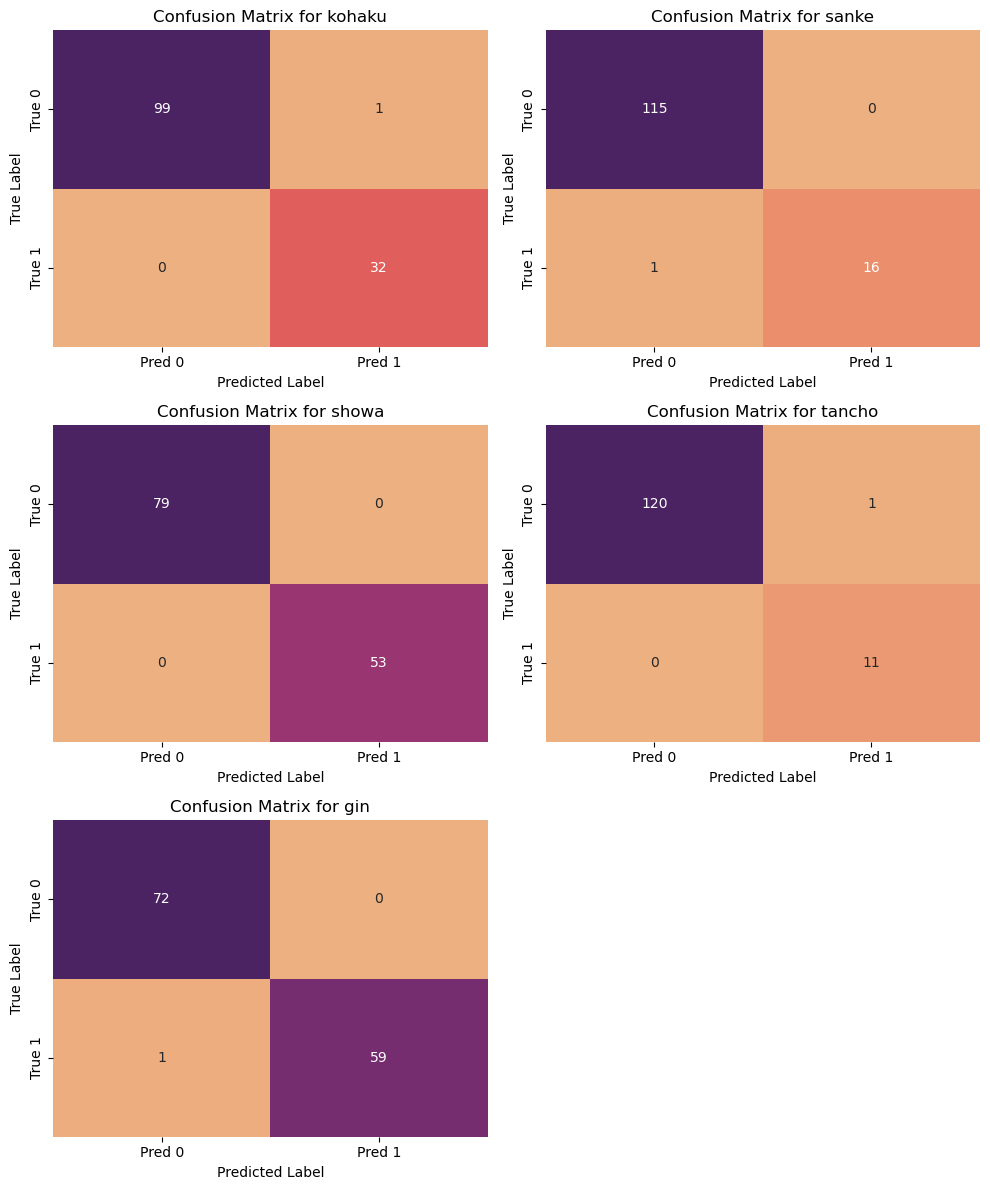

In [17]:
# Evaluate the model
all_preds, all_labels, scores = evaluate_model_flare(model, test_loader, device, class_labels=LABELS)

## Check the Wrong Predictions

In [37]:
# Determine if all labels were predicted correctly
all_preds_tensor = torch.tensor(all_preds)
all_labels_tensor = torch.tensor(all_labels)
matches = (all_preds_tensor == all_labels_tensor).all(dim=1).float() # checks if all labels match

wrong_predictions = []
for i, match in enumerate(matches):
  if match == 0:
    wrong_predictions.append(i)

wrong_predictions

[46, 79, 92, 109]

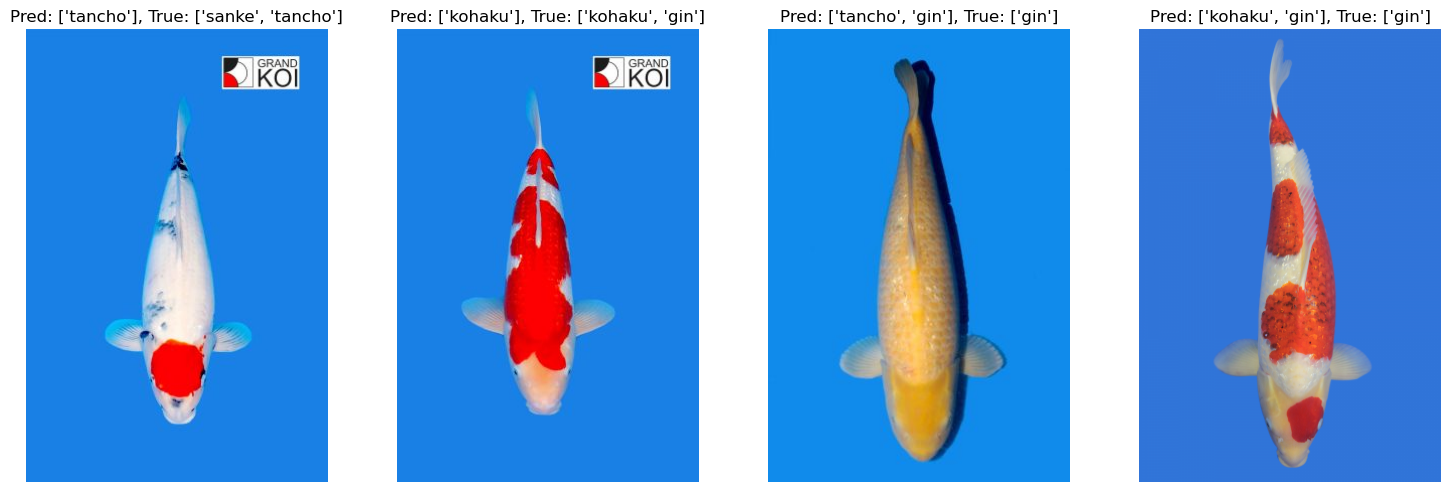

In [94]:
# check which pictures the model got incorrectly
LABELS = {0:'kohaku', 1:'sanke', 2:'showa', 3:'tancho', 4:'gin'}

# for each wrong prediction show the image along with the predicted label and the true label
fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i, idx in enumerate(wrong_predictions):

  image_path = 'pictures/' + test_df['image_path'].iloc[idx]
  image = mpimg.imread(image_path)

  preds = all_preds[idx]
  preds_list = []
  for j, pred in enumerate(preds):
    if pred==1:
      preds_list.append(LABELS[j])

  trues = all_labels[idx]
  trues_list = []
  for k, true in enumerate(trues):
    if true==1:
      trues_list.append(LABELS[k])

  ax[i].imshow(image)
  ax[i].set_title(f'Pred: {preds_list}, True: {trues_list}')
  ax[i].axis('off')

plt.tight_layout()
plt.savefig('0_main_dataset/graphics/mistakes.png', transparent=True)
plt.show()


# Check Correct Predictions

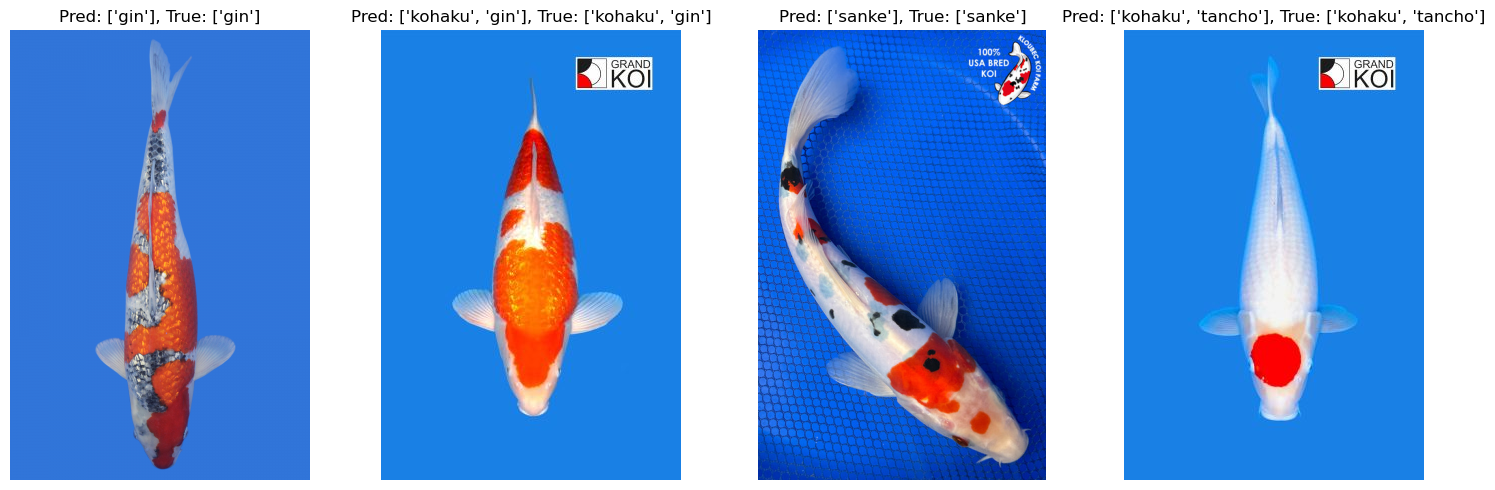

In [93]:
# check which pictures the model got incorrectly
LABELS = {0:'kohaku', 1:'sanke', 2:'showa', 3:'tancho', 4:'gin'}

# for each wrong prediction show the image along with the predicted label and the true label
fig, ax = plt.subplots(1, 4, figsize=(15,5))

# 33 sparkly kohaku
# 60 look like tancho but not tancho because it has red on body
# 110 sparkly

for i, idx in enumerate([110,33,126,35]):

  image_path = 'pictures/' + test_df['image_path'].iloc[idx]
  image = mpimg.imread(image_path)

  preds = all_preds[idx]
  preds_list = []
  for j, pred in enumerate(preds):
    if pred==1:
      preds_list.append(LABELS[j])

  trues = all_labels[idx]
  trues_list = []
  for k, true in enumerate(trues):
    if true==1:
      trues_list.append(LABELS[k])

  ax[i].imshow(image)
  ax[i].set_title(f'Pred: {preds_list}, True: {trues_list}')
  ax[i].axis('off')

plt.tight_layout()
plt.savefig('0_main_dataset/graphics/correct.png', transparent=True)
plt.show()
